In [1]:
import os
import time
import copy

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
import torch
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

import utils

%matplotlib inline
plt.style.use('fivethirtyeight')
%reload_ext autoreload
%autoreload 2

In [2]:
# Set global variables
PATH = 'data/dogscats/' # root directory of images
bs = 20                 # batch size
sz = 224                # image size

In [3]:
os.listdir(PATH)

['valid', '.DS_Store', 'test', 'train']

In [4]:
# Only normalize and convert to tensor
tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(sz),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])]
    )

In [5]:
# Define datasets and dataloaders
sets = ['train', 'valid', 'test']
images_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          transform=tfms)
                  for x in sets}
data_loaders = {x: DataLoader(images_datasets[x], batch_size=bs,
                             shuffle=True, num_workers=4)
               for x in sets}
dataset_sizes = {x: len(images_datasets[x]) for x in sets}
dataset_sizes, images_datasets['train'].class_to_idx

({'train': 1000, 'valid': 500, 'test': 1000}, {'cats': 0, 'dogs': 1})

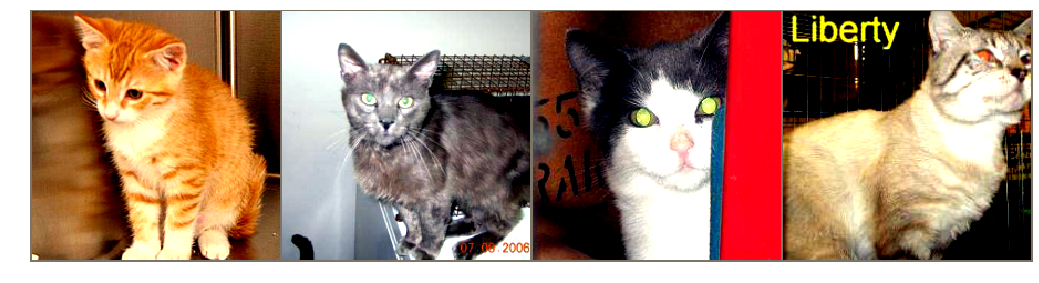

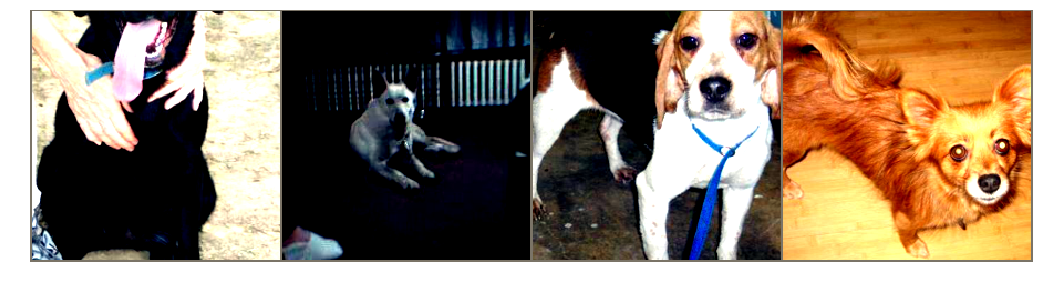

In [6]:
# Plot grid of images
samples, labels = next(iter(data_loaders['train']))
cat_labels, dog_labels = labels == 0, labels == 1
# mean and std used to normalize the images
mean = [0.485, 0.456, 0.406]
std = [0.485, 0.456, 0.406] 
utils.show_images(torchvision.utils.make_grid(samples[cat_labels][:4]), mean, std)
utils.show_images(torchvision.utils.make_grid(samples[dog_labels][:4]), mean, std)

In [7]:
device = ("gpu:0" if torch.cuda.is_available() else "cpu:0")
device

'cpu:0'

In [8]:
# Define ConvNet
class Net(nn.Module):
    """Build a ConvNet"""
    
    def __init__(self):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
net = Net()
net = net.to(device)
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [10]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=10):
    """Train neural network model and returns the best weights"""
    since = time.time()
    history = {'train_acc': [], 'train_loss': [],
               'valid_acc': [], 'valid_loss': []}

    # Copy best model
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0

    # Iterate over the whole dataset num_epochs times
    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}:')
        print(11 * '-')

        for phase in ['train', 'valid']:
            if phase == 'train':  
                model.train()  # training mode
                if scheduler:
                    scheduler.step()
            else:
                model.eval()  # evaluation mode

            running_loss = 0
            running_acc = 0

            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zeros gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        # Compute grads and update parameters
                        loss.backward()
                        optimizer.step()

                # Compute statistics
                running_loss += loss.item() * inputs.size()[0]
                preds = torch.argmax(outputs, 1)
                running_acc += (preds == labels).sum().item()

            # Compute statistics at the epoch level
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_acc / dataset_sizes[phase]
            print(f'{phase:<5s} Loss : {epoch_loss:.4f} Acc : {epoch_acc:.2%}')

            # Append metrcis to history
            history[phase + '_acc'].append(epoch_acc)
            history[phase + '_loss'].append(epoch_loss)

            # Check if accuracy is > best accuracy to save model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
        print()
    # Compute time took for training
    time_elapsed = time.time() - since
    print(f'Training complete in  {time_elapsed // 60}m ' +
          f'and {time_elapsed % 60:0.0f} seconds.')

    # Load best model
    model.load_state_dict(best_model_weights)

    return model, history

In [11]:
# Define optimizer and loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=1e-4)
net, history = train_model(net, criterion, optimizer, num_epochs=10)

Epoch 1/10:
-----------
train Loss : 0.7268 Acc : 52.80%
valid Loss : 0.6754 Acc : 56.60%

Epoch 2/10:
-----------
train Loss : 0.6694 Acc : 59.30%
valid Loss : 0.6611 Acc : 61.20%

Epoch 3/10:
-----------
train Loss : 0.6378 Acc : 63.30%
valid Loss : 0.6163 Acc : 65.80%

Epoch 4/10:
-----------
train Loss : 0.6174 Acc : 66.70%
valid Loss : 0.6121 Acc : 64.40%

Epoch 5/10:
-----------
train Loss : 0.5687 Acc : 70.00%
valid Loss : 0.5985 Acc : 65.80%

Epoch 6/10:
-----------
train Loss : 0.5293 Acc : 73.80%
valid Loss : 0.6016 Acc : 67.20%

Epoch 7/10:
-----------
train Loss : 0.4816 Acc : 76.70%
valid Loss : 0.6086 Acc : 68.40%

Epoch 8/10:
-----------
train Loss : 0.4435 Acc : 80.10%
valid Loss : 0.6473 Acc : 66.40%

Epoch 9/10:
-----------
train Loss : 0.4071 Acc : 82.20%
valid Loss : 0.5878 Acc : 70.40%

Epoch 10/10:
-----------
train Loss : 0.3545 Acc : 85.90%
valid Loss : 0.7176 Acc : 66.40%

Training complete in  24.0m and 9 seconds.


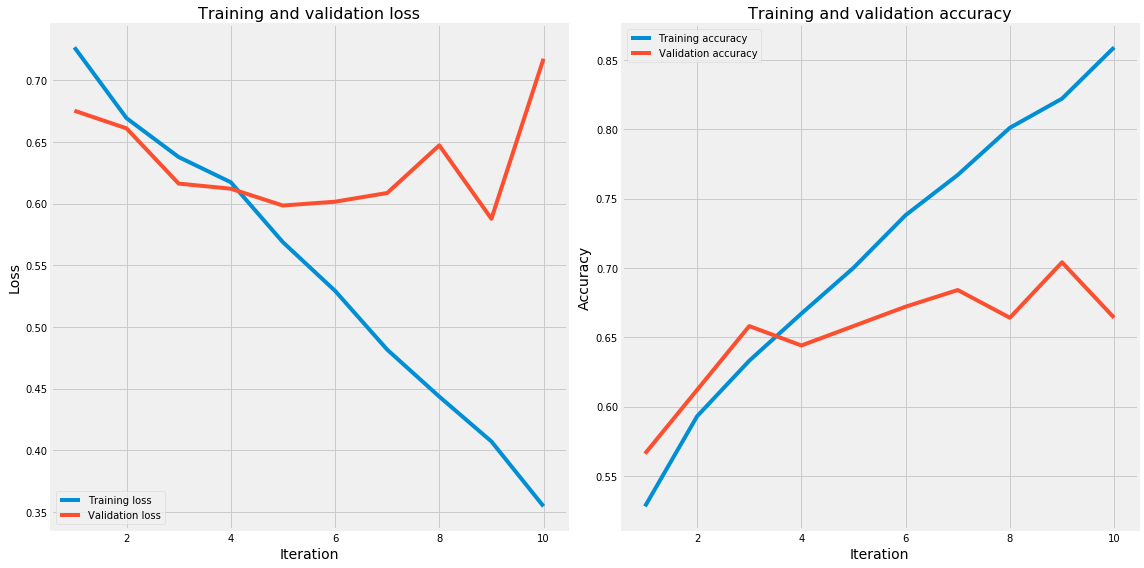

In [12]:
plot_loss_and_metric(history)

In [ ]:
# Save the model in case anything goes wrong
torch.save(net.state_dict(), 'simple_model.pth')

In [11]:
# Load model
net = Net()
net.load_state_dict(torch.load('simple_model.pth'))

In [12]:
valid = utils.validate(net, data_loaders['valid'])

In [13]:
probs_val, correct_labels_val, data_val_imgs, data_val_y = valid.values()

Correctly classified


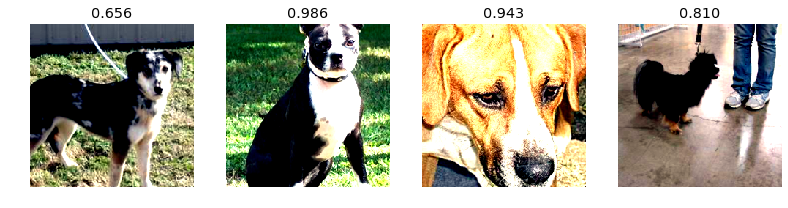

In [14]:
# Plot randomly correctly classified images
idxs = utils.rand_by_correct(
    is_correct=True, correct_labels_val=correct_labels_val, num_images=4)
utils.plot_val_images(idxs, data_val_imgs, data_val_y, probs_val, mean, std,
                      num_images=4, title='Correctly classified')

Incorrectly classified


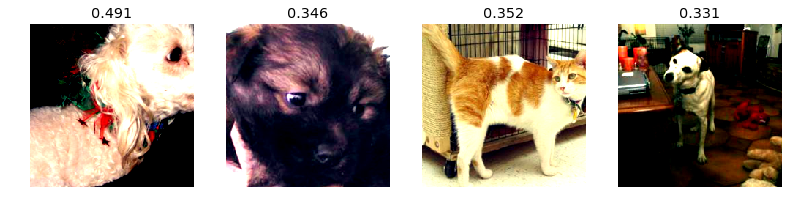

In [15]:
# Plot randomly incorrectly classified images
idxs = utils.rand_by_correct(
    is_correct=False, correct_labels_val=correct_labels_val, num_images=4)
utils.plot_val_images(idxs, data_val_imgs, data_val_y, probs_val, mean, std,
                      num_images=4, title='Incorrectly classified')

Most correct dogs


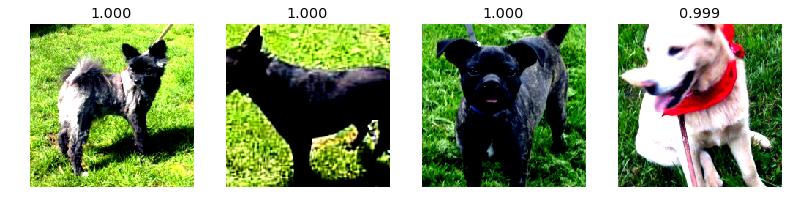

In [16]:
# Plot most correctly classified dogs
idxs = utils.most_by_correct(1, True, data_val_y, correct_labels_val, probs_val)
utils.plot_val_images(idxs, data_val_imgs, data_val_y, probs_val, mean, std,
                      num_images=4, title='Most correct dogs')

Most incorrect dogs


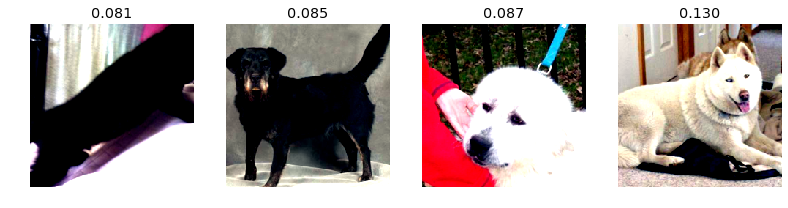

In [17]:
# Plot most incorrectly classified dogs
idxs = utils.most_by_correct(1, False, data_val_y, correct_labels_val, probs_val)
utils.plot_val_images(idxs, data_val_imgs, data_val_y, probs_val, mean, std,
                      num_images=4, title='Most incorrect dogs')

Most correct cats


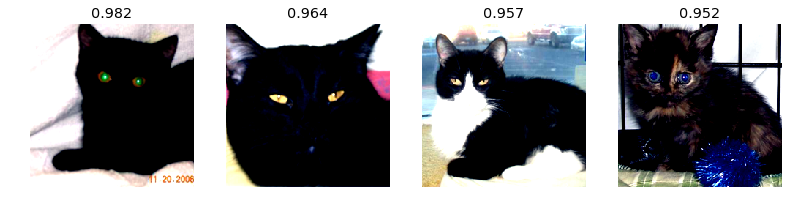

In [18]:
# Plot most correctly classified cats
idxs = utils.most_by_correct(0, True, data_val_y, correct_labels_val, probs_val)
utils.plot_val_images(idxs, data_val_imgs, data_val_y, probs_val, mean, std,
                      num_images=4, title='Most correct cats')

Most incorrect cats


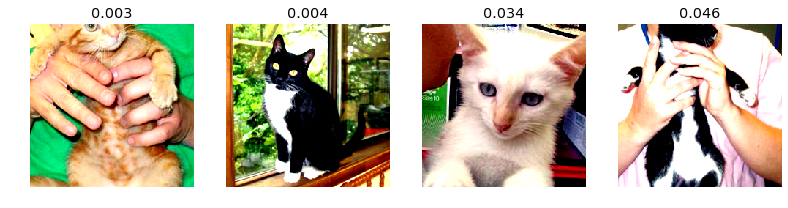

In [19]:
# Plot most incorrectly classified cats
idxs = utils.most_by_correct(0, False, data_val_y, correct_labels_val, probs_val)
utils.plot_val_images(idxs, data_val_imgs, data_val_y, probs_val, mean, std,
                      num_images=4, title='Most incorrect cats')

In [20]:
# Use pretrained model -- resnet34
net = models.resnet34(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [21]:
# Find the best lr using learning rate finder
log_lr, smoothed_losses = utils.find_lr(
    net, device, criterion, optimizer, init_lr=1e-5, final_lr=1,
    train_dataloader=data_loaders['train'], beta=0.98)

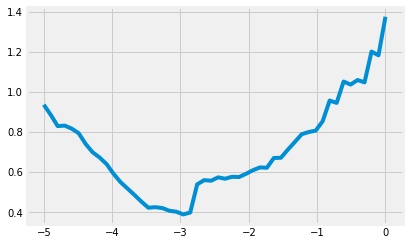

In [22]:
plt.plot(log_lr, smoothed_losses)

In [23]:
# Use pretrained model -- resnet34
net = models.resnet34(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
net, history = train_model(net, criterion, optimizer, num_epochs=5)

Epoch 1/5:
-----------
train Loss : 0.1285 Acc : 95.00%
valid Loss : 0.0581 Acc : 97.60%

Epoch 2/5:
-----------
train Loss : 0.0238 Acc : 99.30%
valid Loss : 0.0619 Acc : 97.60%

Epoch 3/5:
-----------
train Loss : 0.0128 Acc : 99.70%
valid Loss : 0.0550 Acc : 98.20%

Epoch 4/5:
-----------
train Loss : 0.0086 Acc : 99.80%
valid Loss : 0.0563 Acc : 98.00%

Epoch 5/5:
-----------
train Loss : 0.0090 Acc : 99.70%
valid Loss : 0.0582 Acc : 97.80%

Training complete in  32.0m and 15 seconds.


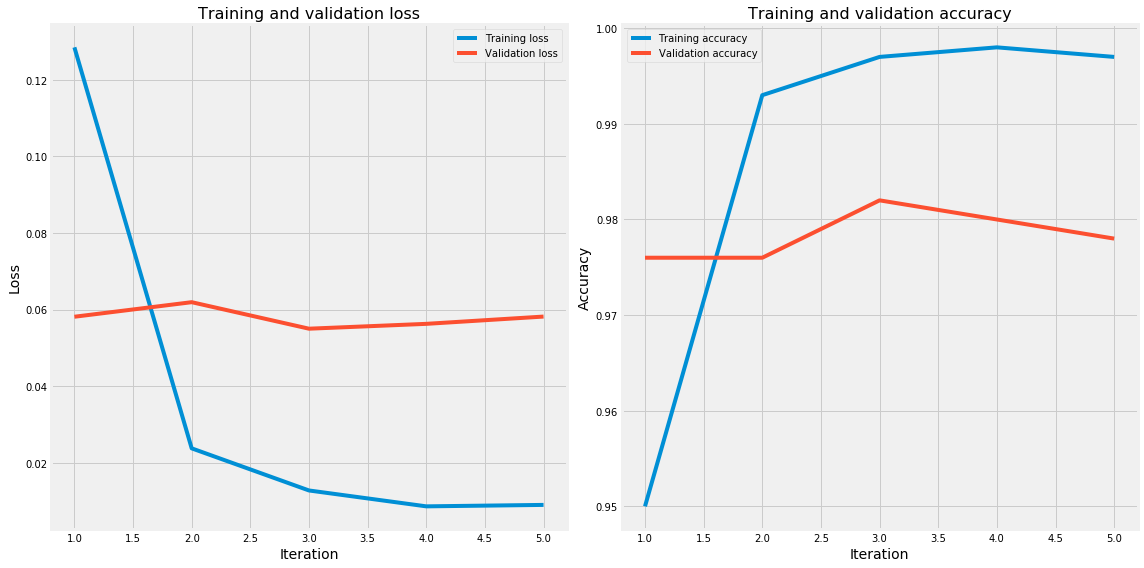

In [24]:
utils.plot_loss_and_metric(history)

In [25]:
torch.save(net.state_dict(), 'resnet34_no_aug_lr_10e4.pth')

In [47]:
# Use pretrained model -- resnet34
net = models.resnet34(pretrained=True)

# Use convnet as a feature extractor then add the classifier on top
# means we'll only train the last layer (classifier)
for param in net.parameters():
    param.requures_grad = False

net.fc = nn.Linear(net.fc.in_features, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
net, history = train_model(net, criterion, optimizer, num_epochs=3)

Epoch 1/3:
-----------
train Loss : 0.1174 Acc : 96.40%
valid Loss : 0.0552 Acc : 97.80%

Epoch 2/3:
-----------
train Loss : 0.0457 Acc : 98.40%
valid Loss : 0.0966 Acc : 97.00%

Epoch 3/3:
-----------
train Loss : 0.0185 Acc : 99.40%
valid Loss : 0.0760 Acc : 97.00%

Training complete in  21.0m and 7 seconds.


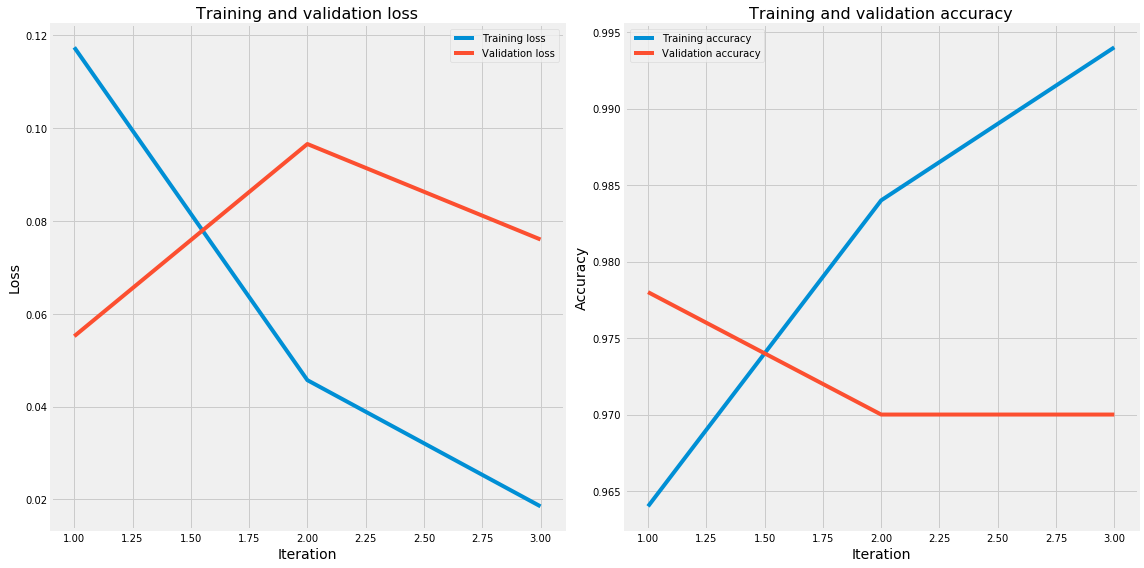

In [48]:
utils.plot_loss_and_metric(history)

In [25]:
# Apply data augmentation only to training data
tfms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(sz),
        transforms.RandomRotation(40),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(sz),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])
}

In [26]:
# Define datasets and dataloaders
sets = ['train', 'valid', 'test']
images_datasets = {x: datasets.ImageFolder(os.path.join(PATH, x),
                                          transform=tfms[x])
                  for x in sets}
data_loaders = {x: DataLoader(images_datasets[x], batch_size=bs,
                             shuffle=True, num_workers=4)
               for x in sets}
dataset_sizes = {x: len(images_datasets[x]) for x in sets}
dataset_sizes, images_datasets['train'].class_to_idx

({'train': 1000, 'valid': 500, 'test': 1000}, {'cats': 0, 'dogs': 1})

In [27]:
# Use pretrained model -- resnet34
net = models.resnet34(pretrained=True)

# Use convnet as a feature extractor then add the classifier on top
# means we'll only train the last layer (classifier)
for param in net.parameters():
    param.requures_grad = False

net.fc = nn.Linear(net.fc.in_features, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
net, history = train_model(net, criterion, optimizer, num_epochs=3)

Epoch 1/3:
-----------
train Loss : 0.1825 Acc : 92.90%
valid Loss : 0.0801 Acc : 96.40%

Epoch 2/3:
-----------
train Loss : 0.0784 Acc : 96.70%
valid Loss : 0.0744 Acc : 97.20%

Epoch 3/3:
-----------
train Loss : 0.0835 Acc : 96.40%
valid Loss : 0.0511 Acc : 98.40%

Training complete in  19.0m and 50 seconds.


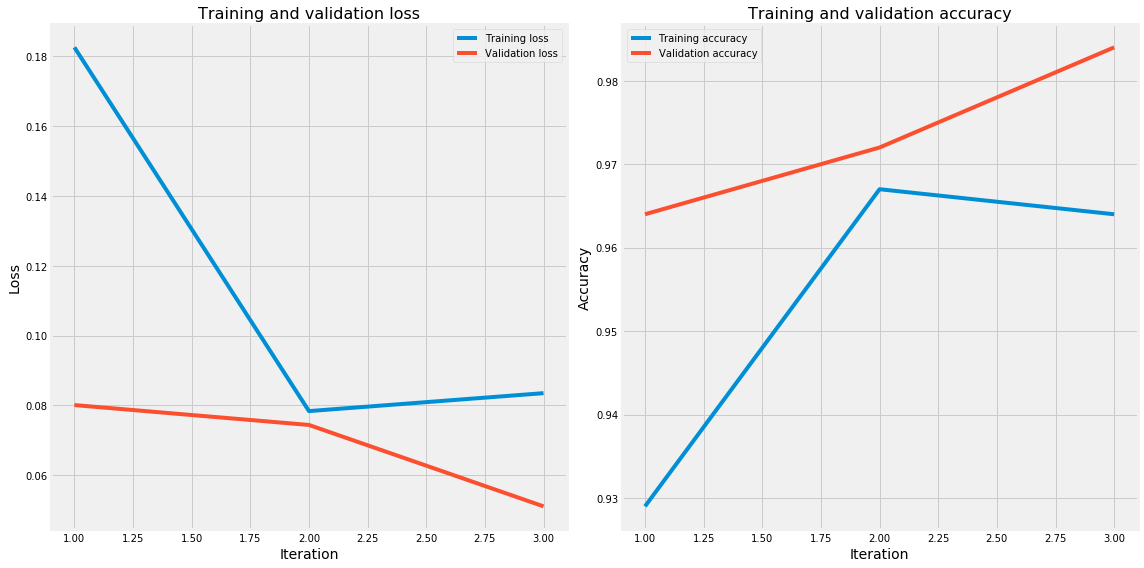

In [28]:
utils.plot_loss_and_metric(history)

In [29]:
net, history1 = train_model(net, criterion, optimizer, num_epochs=3)

Epoch 1/3:
-----------
train Loss : 0.0529 Acc : 98.20%
valid Loss : 0.0446 Acc : 97.60%

Epoch 2/3:
-----------


Process Process-48:
Process Process-46:
Process Process-47:
Process Process-45:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  Fi

RuntimeError: DataLoader worker (pid 2858) exited unexpectedly with exit code 1.